This notebook implements a Transformer-based model to classify hand trajectory sequences into target points. It uses the self-attention mechanism of Transformers to capture temporal relationships in the 3D movement data. It also saves the model and evaluate the performance.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LayerNormalization, MultiHeadAttention, Dense, Dropout, GlobalAveragePooling1D, Add
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf

In [3]:
# Load the data
df = pd.read_csv("hand_trajectory_labeled_new_edit.csv")

# Assumption: df has columns like ['point_id', 'sequence_id', 'x', 'y', 'z']
grouped = df.groupby(['point_id', 'sequence_id'])

X = []
y = []

for (point_id, seq_id), group in grouped:
    coords = group[['x_px', 'y_px', 'z_mm']].values
    X.append(coords)
    y.append(point_id)

# Padding/truncating to same length
MAX_LEN = max(len(seq) for seq in X)
X_pad = pad_sequences(X, maxlen=MAX_LEN, dtype='float32', padding='post', truncating='post')

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

# Transformer Model
def build_transformer_model(seq_len, feature_dim, num_classes):
    inputs = tf.keras.Input(shape=(seq_len, feature_dim))

    x = tf.keras.layers.LayerNormalization()(inputs)
    x = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_transformer_model(seq_len=MAX_LEN, feature_dim=3, num_classes=9)
model.summary()

# Train
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=8)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 79, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 79, 3)     │          6 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 79, 3)     │      1,923 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 3)         │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 9)         │        585 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770 (10.82 KB)

 Trainable params: 2,770 (10.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1970 - loss: 2.1959 - val_accuracy: 0.0455 - val_loss: 2.2028
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1378 - loss: 2.1887 - val_accuracy: 0.0455 - val_loss: 2.1950
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1768 - loss: 2.1790 - val_accuracy: 0.1818 - val_loss: 2.1733
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2414 - loss: 2.1380 - val_accuracy: 0.1818 - val_loss: 2.1456
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2571 - loss: 2.1053 - val_accuracy: 0.1364 - val_loss: 2.1105
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3421 - loss: 2.0332 - val_accuracy: 0.1364 - val_loss: 2.0578
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1661 - loss: 2.0081 - val_accuracy: 0.1818 - val_loss: 1.9903
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2485 - loss: 1.9213 - val_accuracy: 0.1818 - va

In [4]:
model.save("hand_motion_transformer.keras")

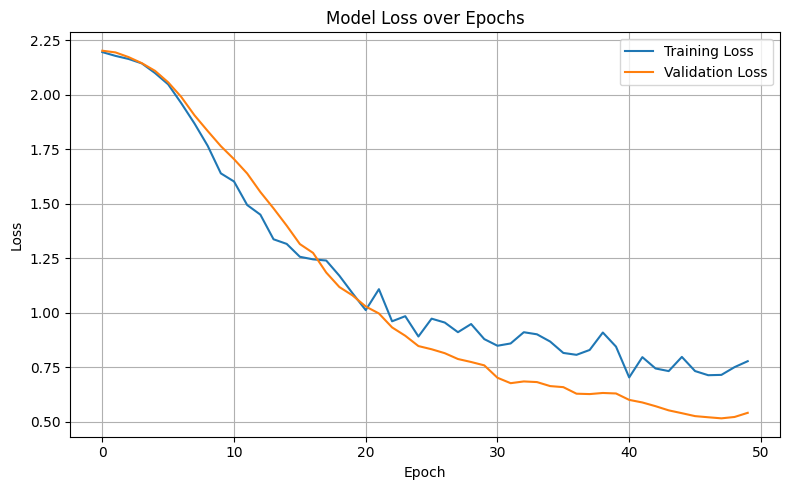

In [ ]:
# Extract loss values
train_loss = history.history['loss']
val_loss = history.history.get('val_loss')

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training Loss')
if val_loss is not None:
    plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


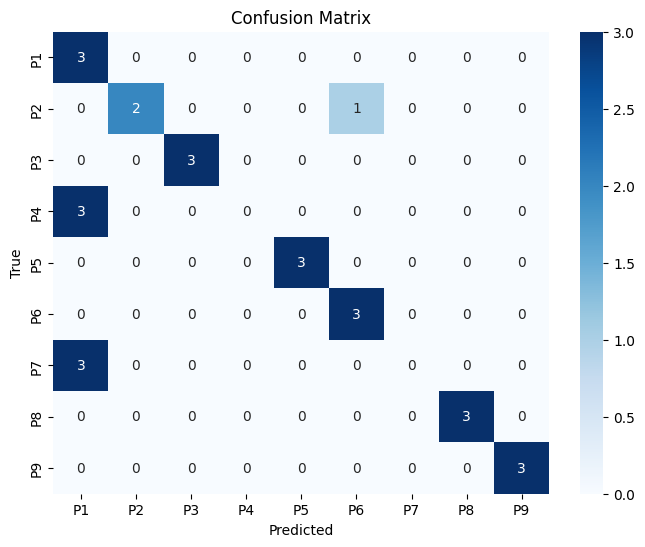

              precision    recall  f1-score   support

          P1       0.33      1.00      0.50         3
          P2       1.00      0.67      0.80         3
          P3       1.00      1.00      1.00         3
          P4       0.00      0.00      0.00         3
          P5       1.00      1.00      1.00         3
          P6       0.75      1.00      0.86         3
          P7       0.00      0.00      0.00         3
          P8       1.00      1.00      1.00         3
          P9       1.00      1.00      1.00         3

    accuracy                           0.74        27
   macro avg       0.68      0.74      0.68        27
weighted avg       0.68      0.74      0.68        27



C:\Users\goga_\anaconda3\envs\hand\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\goga_\anaconda3\envs\hand\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\goga_\anaconda3\envs\hand\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:

# Predict on test data
y_pred = model.predict(X_test)
y_pred_label = np.argmax(y_pred, axis=1)
y_true_label = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_label, y_pred_label)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_label, y_pred_label, target_names=le.classes_))


In [10]:
import cv2
import mediapipe as mp
import pyrealsense2 as rs
import numpy as np
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib
from collections import deque, Counter

# ─────────────── Load Transformer Model and Encoder ───────────────
model = load_model("hand_motion_transformer.keras")
label_encoder = joblib.load("label_encoder_new.pkl")

MAX_LEN = 79
trajectory = []
recent_predictions = deque(maxlen=10)
stable_label = None

# ─────────────── RealSense Setup ───────────────
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
pipeline.start(config)
align = rs.align(rs.stream.color)

# ─────────────── MediaPipe Setup ───────────────
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1,
                       min_detection_confidence=0.7,
                       min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

try:
    while True:
        frames = pipeline.wait_for_frames()
        aligned = align.process(frames)
        depth_frame = aligned.get_depth_frame()
        color_frame = aligned.get_color_frame()

        if not depth_frame or not color_frame:
            continue

        color_image = np.asanyarray(color_frame.get_data())
        frame_rgb = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(color_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                h, w, _ = color_image.shape
                lm = hand_landmarks.landmark[8]
                cx, cy = int(lm.x * w), int(lm.y * h)
                cx, cy = np.clip(cx, 0, w - 1), np.clip(cy, 0, h - 1)
                z = depth_frame.get_distance(cx, cy) * 1000  # mm
                trajectory.append([cx, cy, z])

                if len(trajectory) > MAX_LEN:
                    trajectory = trajectory[-MAX_LEN:]

                if len(trajectory) >= MAX_LEN:
                    input_seq = pad_sequences([trajectory], maxlen=MAX_LEN, dtype='float32', padding='post')
                    probs = model.predict(input_seq, verbose=0)
                    pred_class = np.argmax(probs)
                    predicted_label = label_encoder.inverse_transform([pred_class])[0]

                    recent_predictions.append(predicted_label)
                    most_common = Counter(recent_predictions).most_common(1)[0]

                    if most_common[1] >= 6:
                        stable_label = most_common[0]

                    if stable_label:
                        cv2.putText(color_image, f"Predicted: {stable_label}", (10, 60),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                # Draw indicator
                cv2.circle(color_image, (cx, cy), 8, (0, 255, 0), -1)
                cv2.putText(color_image, f"{round(z)} mm", (cx + 10, cy - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

        cv2.imshow("Real-Time Transformer Prediction", color_image)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

except KeyboardInterrupt:
    print("Interrupted by user")

finally:
    print("Closing")
    pipeline.stop()
    cv2.destroyAllWindows()


Closing
